In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [18]:
# session_info = {'date': "16_02_2024",
#                 'genotype_dir': "ER4d_Chrimson88tdT_sytjGCaMP7f",
#                 'fly': 'fly2',
#                 'session': 'dopamine_bath-000',
#                 'full_genotype': '+/w-; +/EPG-AD; UAS-jGCaMP7b^{vk00005}/EPG-DBD (SS00096)',
#                 'ecl date': '2/3-4/2024',
#                 'notes': ''}

# bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

# pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
#                                          bruker_base_dir = bruker_folder,
#                                          fictrac_base_dir = fictrac_folder)






session_info = {'date': "19_02_2024",
                'genotype_dir': "ER4d_Chrimson88tdT_sytjGCaMP7f",
                'fly': 'fly1',
                'session': 'OA_washon_stim-004',
                'full_genotype': '+/UAS-Chrimson88::tdT; +/ER4d-AD; UAS-sytjGCaMP7g^{attp2}/ER4d-DBD (SS00238)',
                'ecl date': '2/11-12/2024',
                'notes': '25 microM picrotoxin, 200 microM OA'}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)


In [4]:
pp.extract_metadata()
pp.bruker_to_h5(overwrite=False,first_chan=1)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)



(277, 320)
[########################################] | 100% Completed | 43.11 s


In [5]:
nap = pp.open_napari()

In [6]:
print()

In [22]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)
y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)

In [23]:
pp.save()

In [19]:
if True:
    n_rois=16
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
   

In [20]:


y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)[1,:,:]
# y = y[1,:,:]/y[0,:,:]
print(y.shape)
# y= sp.ndimage.gaussian_filter1d(sp.ndimage.median_filter(y,(1,3)),3,axis=-1)

(16, 2339)


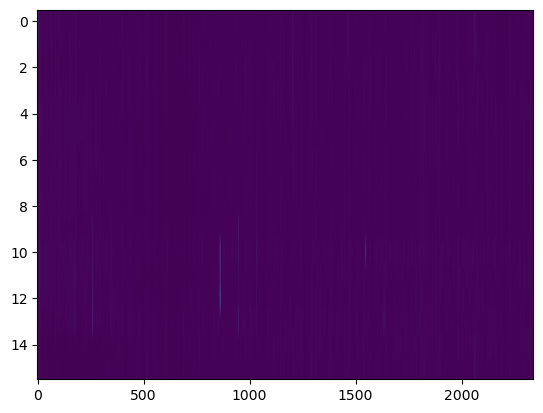

In [21]:
fig, ax = plt.subplots()
ax.imshow(y,aspect='auto')

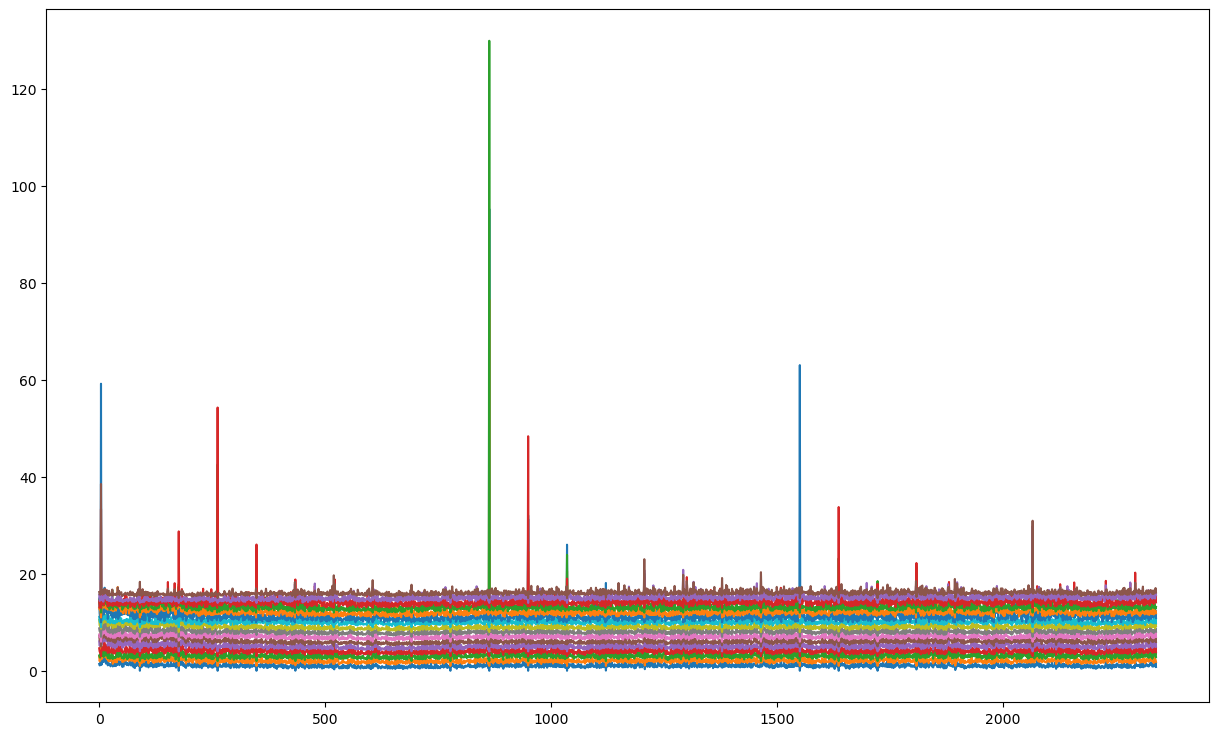

In [22]:
fig, ax = plt.subplots(figsize= [15,9])
# x = pp.voltage_recording_aligned['Time(ms)'].to_numpy()
for r in range(n_rois):
    ax.plot(y[r,:]+r)

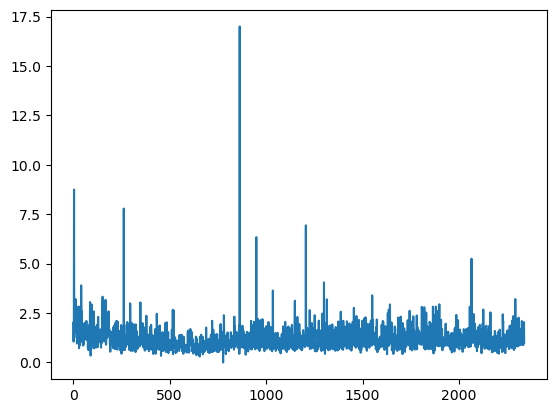

In [23]:
fig, ax = plt.subplots()
ax.plot(y.mean(axis=0))

In [24]:
frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)

In [25]:
pp.metadata['mark_points'].keys()


dict_keys(['iterations', 'iteration_delay', 'repetitions', 'uncaging_laser', 'trigger', 'trigger_freq', 'trigger_count', 'uncaging_power', 'custom_laser_power', 'initial_delay', 'inter_point_delay', 'duration', 'spiral_revolutions', 'indices', 'points_list'])

In [26]:
pp.metadata['mark_points']['iterations']

1

In [27]:
stim_times = [pp.metadata['mark_points']['initial_delay']]
for i in range(pp.metadata['mark_points']['repetitions']-1):
    stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
stim_times = np.array(stim_times)/1000
stim_times = np.cumsum(stim_times)
print(stim_times)

[  0.5  10.6  20.7  30.8  40.9  51.   61.1  71.2  81.3  91.4 101.5 111.6
 121.7 131.8 141.9 152.  162.1 172.2 182.3 192.4 202.5 212.6 222.7 232.8
 242.9]


In [28]:
stim_inds = []
for time in stim_times:
    stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
stim_inds = np.array(stim_inds)

In [29]:
y[:, stim_inds]=np.nan
y[:, stim_inds-1]=np.nan
y[:, stim_inds+1]=np.nan

In [30]:
stim_resp = np.zeros((len(stim_inds)-1, n_rois, 50))
for i, ind in enumerate(stim_inds[1:]):
    stim_resp[i,:,:] = y[:, ind-10:ind+40]
stim_resp -= np.nanmean(stim_resp[:,:,:10], axis=-1, keepdims=True)


/tmp/ipykernel_669345/4290193065.py:2: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(np.nanmean(stim_resp,axis=0),axis=0)
/tmp/ipykernel_669345/4290193065.py:3: RuntimeWarning: Mean of empty slice
  sem = sp.stats.sem(np.nanmean(stim_resp, axis=1),axis=0, nan_policy='omit')


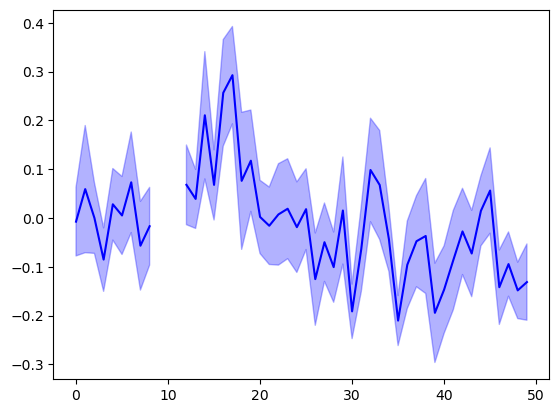

In [31]:
fig, ax= plt.subplots()
mu = np.nanmean(np.nanmean(stim_resp,axis=0),axis=0)
sem = sp.stats.sem(np.nanmean(stim_resp, axis=1),axis=0, nan_policy='omit')

x = np.arange(50)
ax.plot(x, mu, color='blue')
ax.fill_between(x, mu-sem, mu+sem, color='blue', alpha=.3)

/tmp/ipykernel_669345/1080395922.py:2: RuntimeWarning: Mean of empty slice
  ax.imshow(np.nanmean(stim_resp,axis=0))
/tmp/ipykernel_669345/1080395922.py:8: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(np.nanmean(stim_resp[:,in_pump_path,:],axis=0),axis=0)
/tmp/ipykernel_669345/1080395922.py:9: RuntimeWarning: Mean of empty slice
  sem = sp.stats.sem(np.nanmean(stim_resp[:,in_pump_path,:],axis=1),axis=0, nan_policy='omit')
/tmp/ipykernel_669345/1080395922.py:17: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(np.nanmean(stim_resp[:,out_pump_path,:],axis=0),axis=0)
/tmp/ipykernel_669345/1080395922.py:18: RuntimeWarning: Mean of empty slice
  sem = sp.stats.sem(np.nanmean(stim_resp[:,out_pump_path,:],axis=1),axis=0, nan_policy='omit')


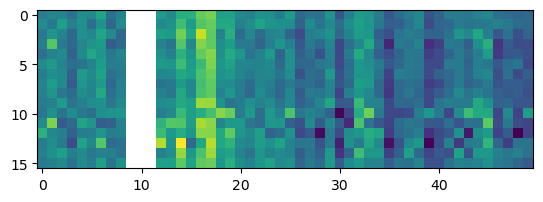

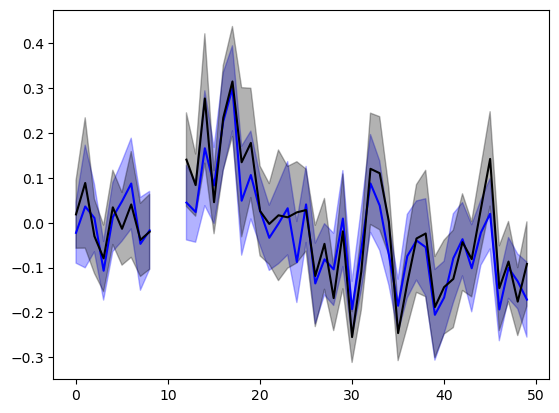

In [32]:
fig, ax= plt.subplots()
ax.imshow(np.nanmean(stim_resp,axis=0))

in_pump_path = [ 4,5,6]
out_pump_path = [10, 11, 12, 13, 14]

fig, ax= plt.subplots()
mu = np.nanmean(np.nanmean(stim_resp[:,in_pump_path,:],axis=0),axis=0)
sem = sp.stats.sem(np.nanmean(stim_resp[:,in_pump_path,:],axis=1),axis=0, nan_policy='omit')

x = np.arange(50)
ax.plot(x, mu, color='blue')
ax.fill_between(x, mu-sem, mu+sem, color='blue', alpha=.3)



mu = np.nanmean(np.nanmean(stim_resp[:,out_pump_path,:],axis=0),axis=0)
sem = sp.stats.sem(np.nanmean(stim_resp[:,out_pump_path,:],axis=1),axis=0, nan_policy='omit')

x = np.arange(50)
ax.plot(x, mu, color='black')
ax.fill_between(x, mu-sem, mu+sem, color='black', alpha=.3)

0.49304347826086947 0.014363733768170055


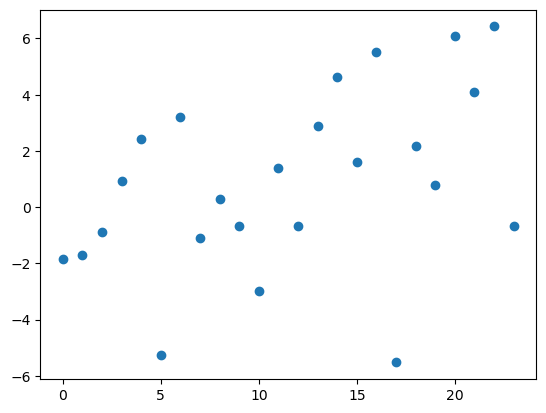

In [33]:
# for i in range(stim_resp.shape[0]):
#     fig, ax= plt.subplots()
#     ax.plot(x, stim_resp[i,:,:].mean(axis=0))
fig,ax = plt.subplots()
ax.scatter(np.arange(24), stim_resp[:,:,12:30].mean(axis=1).sum(axis=-1))
r,p = sp.stats.spearmanr(np.arange(24),stim_resp[:,:,12:30].mean(axis=1).sum(axis=-1))
print(r,p)